In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
%%time

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow_hub as hub
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
import tokenization

SEED = 42

CPU times: user 34.3 s, sys: 5.11 s, total: 39.4 s
Wall time: 45.2 s


In [3]:
df_train = pd.read_pickle('../input/nlp-with-disaster-tweets-read-before-start-eda/train.pkl')
df_test = pd.read_pickle('../input/nlp-with-disaster-tweets-read-before-start-eda/test.pkl')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 6)
Training Set Memory Usage = 0.25 MB
Test Set Shape = (3263, 6)
Test Set Memory Usage = 0.13 MB


In [4]:
X_train = df_train['text_cleaned'].values
y_train = df_train['target'].values
X_test = df_test['text_cleaned'].values
y_test = df_test['target'].values

In [5]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        self.X_train, self.y_train = train_data
        self.X_val, self.y_val = validation_data
                
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))       
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))        

class DisasterDetector:
    
    def __init__(self, bert_layer, epochs, lr=0.0001, decay=False, max_len=160):
        
        if decay == True:
            self.lr = lr
        else:
            self.lr = ExponentialDecay(lr, decay_steps=10000, decay_rate=0.90, staircase=True)
        self.epochs = epochs
        
        self.models = []
        
        self.max_len = max_len
        self.bert_layer = bert_layer
        self.vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        self.do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(self.vocab_file, self.do_lower_case)
        
        
    def encode(self, texts, tokenizer, max_len):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_len - 2]
            input_sequence = ["[CLS]"] + text + ["[SEP]"]
            pad_len = self.max_len - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_len

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

    
    def build_model(self):
        input_word_ids = Input(shape=(self.max_len,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_len,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_len,), dtype=tf.int32, name='segment_ids')

        _, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        clf_output = sequence_output[:, 0, :]
        dense_layer1 = Dense(units=128,activation='relu')(clf_output)
        dense_layer1 = Dropout(0.1)(dense_layer1)
        dense_layer2 = Dense(units=64, activation='relu')(dense_layer1)
        dense_layer2 = Dropout(0.1)(dense_layer2)
        dense_layer3 = Dense(units=32, activation='relu')(dense_layer2)
        dense_layer3 = Dropout(0.1)(dense_layer3)
        out = Dense(1, activation='sigmoid')(dense_layer3)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, nesterov=True)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, fold):

        X_train_encoded = self.encode(X_train, self.tokenizer, max_len=self.max_len)
        X_val_encoded = self.encode(X_val, self.tokenizer, max_len=self.max_len)
        
        metrics = ClassificationReport(train_data=(X_train_encoded, y_train), validation_data=(X_val_encoded, y_val))
        
        self.models.append(self.build_model())
        self.models[fold].fit(X_train_encoded, y_train, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=40)
        
    def learning_curve(self):
        
        fig, axes = plt.subplots(ncols=2, figsize=(20, 4), dpi=100)
    
        sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[0], label='train_loss')
        sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[0], label='val_loss')        
        sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['accuracy'], ax=axes[1], label='train_accuracy')
        sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_accuracy'], ax=axes[1], label='val_accuracy')
        
        axes[0].legend()
        axes[1].legend()    
        
        plt.show()
        
    def predict(self, X_test):
        
        X_test_encoded = self.encode(X_test, self.tokenizer, max_len=self.max_len)
        
        return np.round(self.models[0].predict(X_test_encoded)).astype('int')
        


In [6]:
clf = DisasterDetector(bert_layer, lr=0.0008, decay=False, epochs=10, max_len=256)

clf.train(X_train, y_train, X_test, y_test, 0)

Train on 7613 samples, validate on 3263 samples
Epoch 1/10
7600/7613 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.6514
Epoch: 1 - Training Precision: 0.770084 - Training Recall: 0.751875 - Training F1: 0.756029
Epoch: 1 - Validation Precision: 0.774561 - Validation Recall: 0.75621 - Validation F1: 0.760469
7613/7613 [==============================] - 357s 47ms/sample - loss: 0.6296 - accuracy: 0.6518 - val_loss: 0.5242 - val_accuracy: 0.7717
Epoch 2/10
7600/7613 [============================>.] - ETA: 0s - loss: 0.5034 - accuracy: 0.7753
Epoch: 2 - Training Precision: 0.80641 - Training Recall: 0.798875 - Training F1: 0.801615
Epoch: 2 - Validation Precision: 0.79472 - Validation Recall: 0.788181 - Validation F1: 0.790601
7613/7613 [==============================] - 338s 44ms/sample - loss: 0.5031 - accuracy: 0.7755 - val_loss: 0.4532 - val_accuracy: 0.7968
Epoch 3/10
7600/7613 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.8032
Epoch

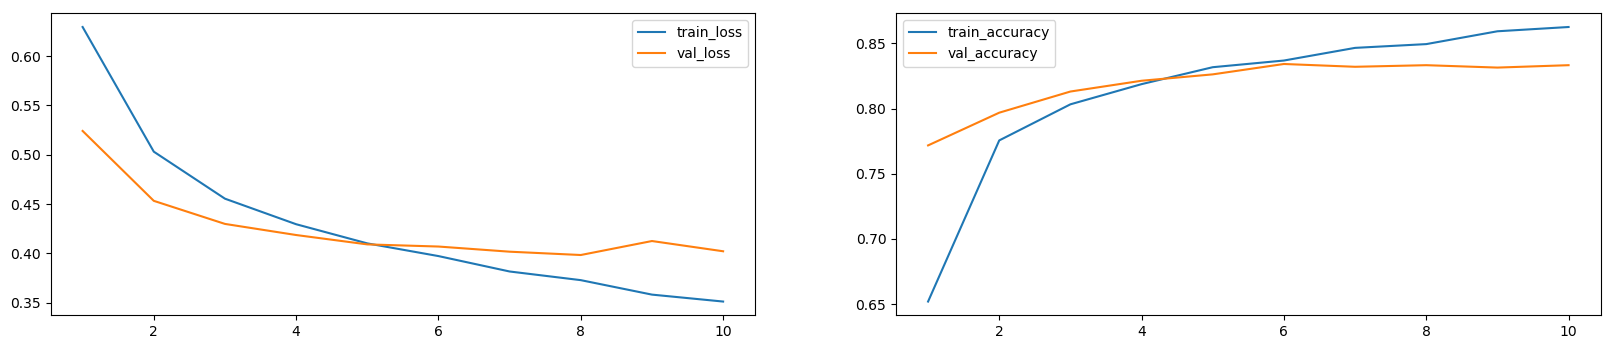

In [7]:
clf.learning_curve()

In [8]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = clf.predict(X_test)
submission.to_csv('submission.csv', index=False)
submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.390438
std,3146.427221,0.487923
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [9]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
